In [1]:
import cv2 as cv 
import matplotlib.pyplot as plt
import pandas  as pd
import numpy as np
import math
from sklearn.cluster import KMeans
from skimage import io
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from scipy.spatial import KDTree

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 导入图片

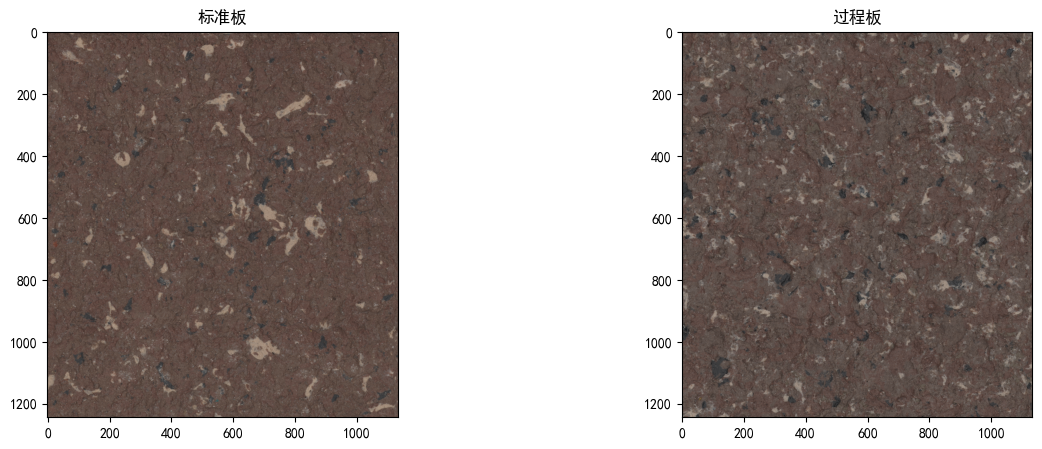

In [2]:
img1 = cv.imread('2BIAOZHUN.png')[:,:,(2,1,0)]
img1_noleft = img1[:,50:]
img2 = cv.imread('2YANGPING.png')[:,:,(2,1,0)]
img2_noleft = img2[:,50:]
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(img1_noleft)
axs[0].set_title(f"标准板")
axs[1].imshow(img2_noleft)
axs[1].set_title(f"过程板")
plt.show()

In [3]:
def get_main_colors(img_noleft):
    image_array = np.array(img_noleft)
    # 将图像数组展平成一维数组
    flattened_array = image_array.reshape(-1, 3)
    num_clusters = 2
    # KMeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(flattened_array)
    cluster_centers = kmeans.cluster_centers_
    # 聚类中心颜色
    cluster_colors = []
    for center in cluster_centers:
        cluster_colors.append(center)
    # print(f"cluster_colors:{cluster_colors}")
    max_colors = 0
    main_colors = []
    for colors in cluster_colors:
        sum_color = sum(x * x for x in colors)
        if sum_color > max_colors:
            main_colors = colors
            max_colors = sum_color
    return (round(main_colors[0]),round(main_colors[1]),round(main_colors[2]))

# 筛选单一颜色

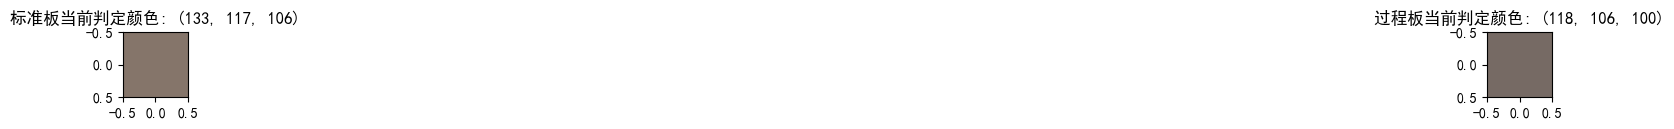

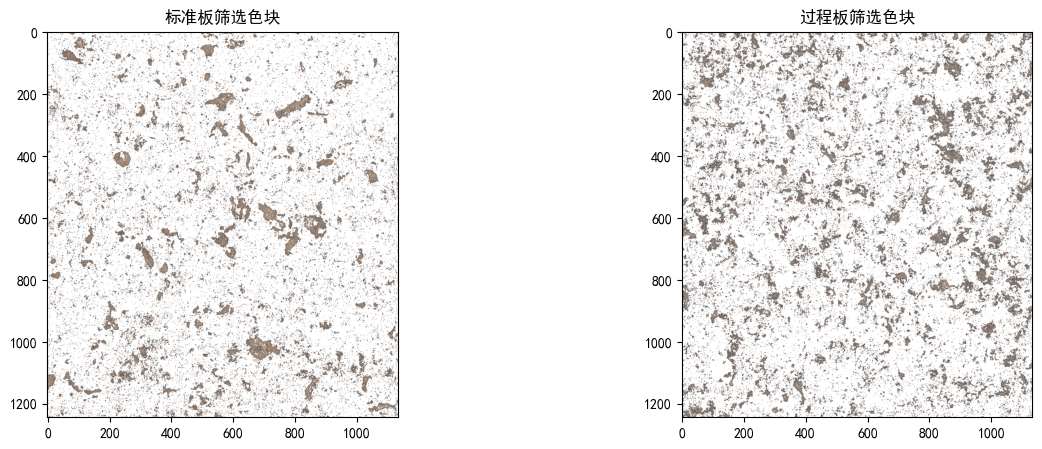

In [4]:
main_colors_1 = get_main_colors(img1_noleft)
main_colors_2 = get_main_colors(img2_noleft)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.tight_layout(h_pad=20)
axs[0].imshow(np.array([[main_colors_1]]))
axs[0].set_title(f"标准板当前判定颜色: {main_colors_1}")
axs[1].imshow(np.array([[main_colors_2]]))
axs[1].set_title(f"过程板当前判定颜色: {main_colors_2}")
plt.subplots_adjust(top=0.85, wspace=20)
plt.show()

tolerance = 50

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

distances1 = np.linalg.norm(img1_noleft - main_colors_1, axis=2)
tempmask1 = distances1 <= tolerance
height1, width1, channels1 = img1_noleft.shape
new_rgb_matrix1 = np.zeros((height1, width1, channels1), dtype=np.uint8)
new_rgb_matrix1[tempmask1] = img1_noleft[tempmask1]
new_rgb_matrix1[~tempmask1] = (255,255,255)
axs[0].imshow(new_rgb_matrix1)
axs[0].set_title("标准板筛选色块")

# distances2 = np.linalg.norm(img2_noleft - main_colors_2, axis=2)
distances2 = np.linalg.norm(img2_noleft - main_colors_1, axis=2)
tempmask2 = distances2 <= tolerance
height2, width2, channels2 = img2_noleft.shape
new_rgb_matrix2 = np.zeros((height2, width2, channels2), dtype=np.uint8)
new_rgb_matrix2[tempmask2] = img2_noleft[tempmask2]
new_rgb_matrix2[~tempmask2] = (255,255,255)
axs[1].imshow(new_rgb_matrix2)
axs[1].set_title("过程板筛选色块")

plt.show()

In [5]:
def get_points(img_gray_ret):
    points_minlen = 30
    recon = np.zeros_like(img_gray_ret)
    x = np.argwhere(img_gray_ret)
    c = DBSCAN(eps=2, min_samples=5).fit(x)
    labels = c.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    # print("n_clusters_:",n_clusters_)
    n_noise_ = list(labels).count(-1)
    X = x
    db = c
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    points = []
    for k, col in zip(unique_labels, colors):
        if k == -1:
            continue
            # Black used for noise.
            col = [0, 0, 0, 1]        
        class_member_mask = labels == k
        xy = X[class_member_mask & core_samples_mask]
        if len(xy) >= points_minlen:
            points.append(xy)
    # print("points:",len(points))
    return points

# 聚类筛选色块

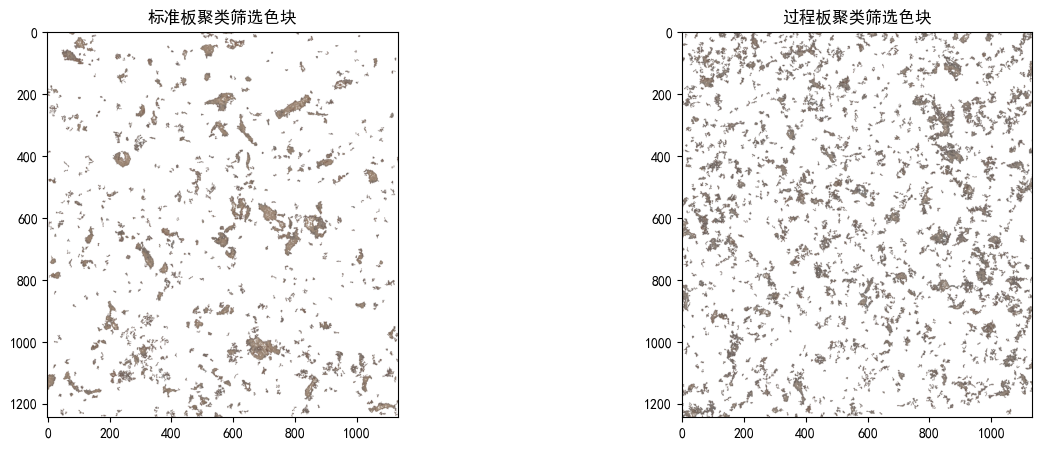

In [6]:
img_gray1 = cv.cvtColor(new_rgb_matrix1,cv.COLOR_BGR2GRAY)
the,ret1 = cv.threshold(img_gray1,254,255,cv.THRESH_BINARY) 
the,ret_1 = cv.threshold(img_gray1,254,255,cv.THRESH_BINARY_INV) 

img_gray2 = cv.cvtColor(new_rgb_matrix2,cv.COLOR_BGR2GRAY)
the,ret2 = cv.threshold(img_gray2,254,255,cv.THRESH_BINARY) 
the,ret_2 = cv.threshold(img_gray2,254,255,cv.THRESH_BINARY_INV) 

# fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# axs[0].imshow(ret1,cmap=plt.get_cmap('gray'))
# axs[0].set_title(f"标准板筛选色块二值化")
# axs[1].imshow(ret2,cmap=plt.get_cmap('gray'))
# axs[1].set_title(f"过程板筛选色块二值化")
# plt.show()

points1 = get_points(ret_1)
points2 = get_points(ret_2)

point_matrix_1 = np.zeros_like(img1_noleft)
recon_1 = np.zeros_like(ret_1)
for c1 in points1:
    recon_1[c1[:,0],c1[:,1]] = 255
point_mask1 = (recon_1 > 1)
point_matrix_1[point_mask1] = img1_noleft[point_mask1]
point_matrix_1[~point_mask1] = (255,255,255)

point_matrix_2 = np.zeros_like(img2_noleft)
recon_2 = np.zeros_like(ret_2)
for c2 in points2:
    recon_2[c2[:,0],c2[:,1]] = 255
point_mask2 = (recon_2 > 1)
point_matrix_2[point_mask2] = img2_noleft[point_mask2]
point_matrix_2[~point_mask2] = (255,255,255)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(point_matrix_1)
axs[0].set_title(f"标准板聚类筛选色块")
axs[1].imshow(point_matrix_2)
axs[1].set_title(f"过程板聚类筛选色块")
plt.show()

In [7]:
temp_lens1 = [len(x) for x in points1]
temp_lens2 = [len(x) for x in points2]

area1 = sum(temp_lens1)
area_rate1 = area1 / (ret_1.shape[0] * ret_1.shape[1])
points_mean1 = np.mean(temp_lens1)
points_variance1 = np.var(temp_lens1)
area2 = sum(temp_lens2)
area_rate2 = area2 / (ret_2.shape[0] * ret_2.shape[1])
points_mean2 = np.mean(temp_lens2)
points_variance2 = np.var(temp_lens2)
print(f"标准板筛选色块总比例占比：{round(area_rate1*100, 2)}%    \t色块大小 均值: {round(points_mean1,3)}, 方差: {round(points_variance1,3)}")
print(f"过程板筛选色块总比例占比：{round(area_rate2*100, 2)}%    \t色块大小 均值: {round(points_mean2,3)}, 方差: {round(points_variance2,3)}")

标准板筛选色块总比例占比：8.14%    	色块大小 均值: 197.924, 方差: 179483.318
过程板筛选色块总比例占比：13.87%    	色块大小 均值: 203.416, 方差: 137882.678


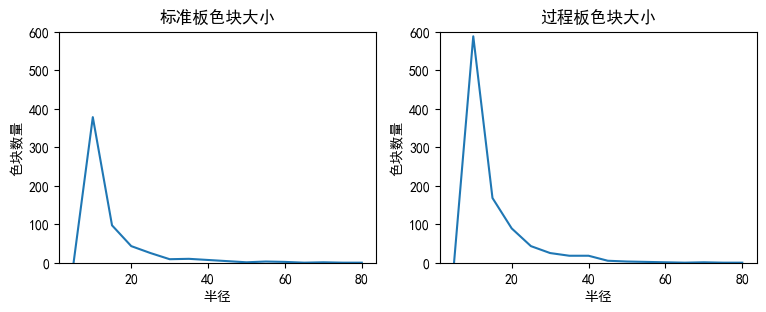

In [8]:
area_step = 5
step_num = round(80 / area_step)
area_list = []
for i in range(step_num):
    area_list.append((i + 1) * area_step)
# print(area_list)
sum_points_list1 = np.zeros_like(area_list)
sum_points_list2 = np.zeros_like(area_list)

for i in range(step_num):
    low = 0
    if i > 0:
        low = area_list[i-1] * area_list[i-1]
    high = area_list[i]*area_list[i]
    sum_points_list1[i] = sum(low < num <= high for num in temp_lens1)
    sum_points_list2[i] = sum(low < num <= high for num in temp_lens2)

fig, axs = plt.subplots(1, 2, figsize=(9,3))
axs[0].plot(area_list, sum_points_list1)
axs[0].set_title(f"标准板色块大小")
axs[1].plot(area_list, sum_points_list2)
axs[1].set_title(f"过程板色块大小")
axs[0].set_ylim(0, 600)
axs[1].set_ylim(0, 600)
axs[0].set_xlabel("半径")
axs[0].set_ylabel("色块数量")
axs[1].set_xlabel("半径")
axs[1].set_ylabel("色块数量")
plt.show()

In [9]:
def get_k_nearest(points_list):
    k = 10
    # 创建 KD 树以快速查找最近邻居
    tree = KDTree(points_list)
    # 初始化 k 近邻距离列表
    k_nearest_neighbor_distances = []
    # 对于每个坐标，找到其最近的 k 个邻居
    for temp_inside in points_list:
        # 查询 KD 树以查找最近的 k 个邻居
        distances, indices = tree.query(temp_inside, k=k+1)
        # 计算 k 近邻距离（不包括查询点本身）
        k_nearest_neighbor_distance = np.mean(distances[1:])
        # 将 k 近邻距离添加到列表中
        k_nearest_neighbor_distances.append(k_nearest_neighbor_distance)
    return k_nearest_neighbor_distances

In [10]:
insides1 = []
for c1 in points1:
    insides1.append((c1[:,0].mean(), c1[:,1].mean()))
insides1 = np.array(insides1)
insides2 = []
for c2 in points2:
    insides2.append((c2[:,0].mean(), c2[:,1].mean()))
insides2 = np.array(insides2)

k_nearest_neighbor_distances1 = get_k_nearest(insides1)
k_nearest_neighbor_distances2 = get_k_nearest(insides2)
knnd_mean1 = np.mean(k_nearest_neighbor_distances1)
knnd_variance1 = np.var(k_nearest_neighbor_distances1)
knnd_mean2 = np.mean(k_nearest_neighbor_distances2)
knnd_variance2 = np.var(k_nearest_neighbor_distances2)
print(f"标准板筛选色块k近邻距离 均值: {round(knnd_mean1,3)}, 方差: {round(knnd_variance1,3)}")
print(f"过程板筛选色块k近邻距离 均值: {round(knnd_mean2,3)}, 方差: {round(knnd_variance2,3)}")

标准板筛选色块k近邻距离 均值: 62.908, 方差: 216.49
过程板筛选色块k近邻距离 均值: 49.881, 方差: 79.73


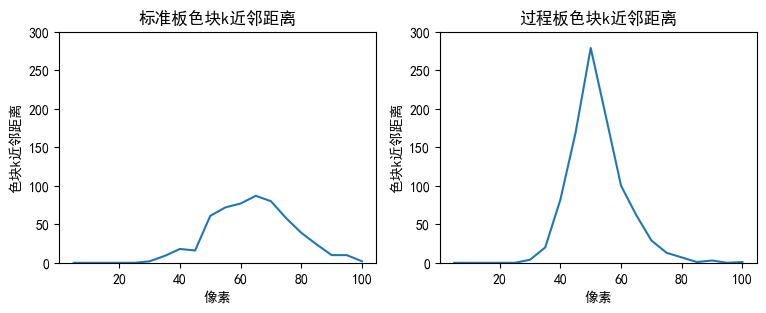

In [11]:
dist_step = 5
step_num = round(100 / dist_step)
dist_list = []
for i in range(step_num):
    dist_list.append((i + 1) * dist_step)
# print(area_list)
sum_dist_list1 = np.zeros_like(dist_list)
sum_dist_list2 = np.zeros_like(dist_list)

for i in range(step_num):
    low = 0
    if i > 0:
        low = dist_list[i-1]
    high = dist_list[i]
    sum_dist_list1[i] = sum(low < num <= high for num in k_nearest_neighbor_distances1)
    sum_dist_list2[i] = sum(low < num <= high for num in k_nearest_neighbor_distances2)

fig, axs = plt.subplots(1, 2, figsize=(9,3))
axs[0].plot(dist_list, sum_dist_list1)
axs[0].set_title(f"标准板色块k近邻距离")
axs[1].plot(dist_list, sum_dist_list2)
axs[1].set_title(f"过程板色块k近邻距离")
axs[0].set_ylim(0, 300)
axs[1].set_ylim(0, 300)
axs[0].set_xlabel("像素")
axs[0].set_ylabel("色块k近邻距离")
axs[1].set_xlabel("像素")
axs[1].set_ylabel("色块k近邻距离")
plt.show()

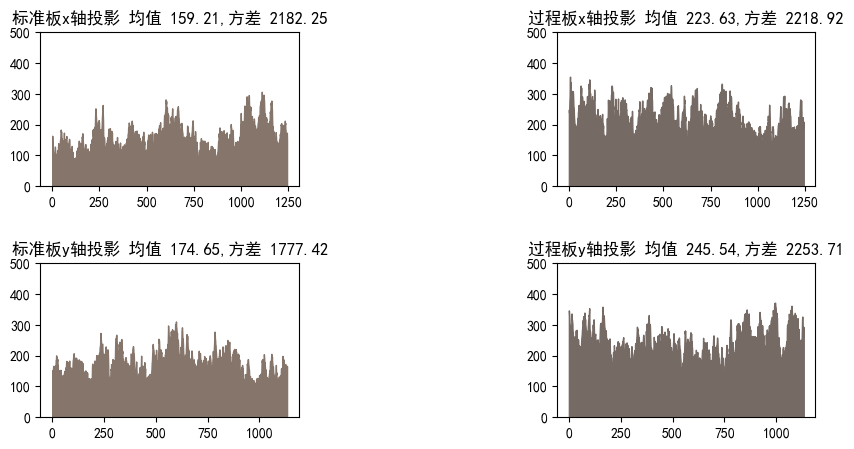

In [12]:
x0_1 = range(ret1.shape[0])
y0_1 = np.sum(ret1 == 0, axis=1)
y0_1_mean = round(np.mean(y0_1),2)
y0_1_var = round(np.var(y0_1),2)
x1_1 = range(ret1.shape[1])
y1_1 = np.sum(ret1 == 0, axis=0)
y1_1_mean = round(np.mean(y1_1),2)
y1_1_var = round(np.var(y1_1),2)
x0_2 = range(ret2.shape[0])
y0_2 = np.sum(ret2 == 0, axis=1)
y0_2_mean = round(np.mean(y0_2),2)
y0_2_var = round(np.var(y0_2),2)
x1_2 = range(ret2.shape[1])
y1_2 = np.sum(ret2 == 0, axis=0)
y1_2_mean = round(np.mean(y1_2),2)
y1_2_var = round(np.var(y1_2),2)
fig, axs = plt.subplots(2, 2, figsize=(10,5))
axs[0][0].fill_between(x0_1,y0_1, 0, color=(main_colors_1[0]/255, main_colors_1[1]/255, main_colors_1[2]/255))
axs[1][0].fill_between(x1_1,y1_1, 0, color=(main_colors_1[0]/255, main_colors_1[1]/255, main_colors_1[2]/255))
axs[0][1].fill_between(x0_2,y0_2, 0, color=(main_colors_2[0]/255, main_colors_2[1]/255, main_colors_2[2]/255))
axs[1][1].fill_between(x1_2,y1_2, 0, color=(main_colors_2[0]/255, main_colors_2[1]/255, main_colors_2[2]/255))
axs[0][0].set_ylim(0,500)
axs[1][0].set_ylim(0,500)
axs[0][1].set_ylim(0,500)
axs[1][1].set_ylim(0,500)
axs[0][0].set_title(f"标准板x轴投影 均值 {y0_1_mean},方差 {y0_1_var}")
axs[1][0].set_title(f"标准板y轴投影 均值 {y1_1_mean},方差 {y1_1_var}")
axs[0][1].set_title(f"过程板x轴投影 均值 {y0_2_mean},方差 {y0_2_var}")
axs[1][1].set_title(f"过程板y轴投影 均值 {y1_2_mean},方差 {y1_2_var}")
plt.subplots_adjust(hspace=0.5, wspace=1)
plt.show()

# 判定总结  
## 1.色块的颜色分析  
    标准板：RGB(133,117,106)  
    过程板：RGB(118,106,100)  
    ---差距明显  
## 2.色块大小分析  
    标准板：色块尺寸平均值 197.924，方差 179483.318  
    过程板：色块尺寸平均值 203.416，方差 137882.678  
    ---过程板的色块尺寸相对标准板来说更为细碎平均  
## 3.色块占比分析  
    标准板：色块总占比  8.14%  
    过程板：色块总占比 13.87%  
    ---差别较大  
## 4.色块离散度分析  
    标准板：色块离散度k近邻距离的均值 62.908， 方差 216.49  
    过程板：色块离散度k近邻距离的均值 49.881， 方差  79.73  
    ---过程板的色块相对标准板来说分布更为零碎广散  
## 5.色块投影分析  
    标准板: 投影 x轴均值159.21,方差2182.25 y轴均值174.65,方差1777.42  
    过程板：投影 x轴均值223.63,方差2218.92 y轴均值245.54,方差2253.71  
    ---过程板在x轴和y轴上的平均值都更高，表明过程板具有更高的中心趋势
    ---投影曲线显示标准板和过程板在投影上的分布形状差异不大